In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
url="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    "aclImdb_v1",url,
    untar=True,cache_dir='.',
    cache_subdir=''
)
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir,"train")
os.listdir(train_dir)


['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
shutil.rmtree(os.path.join(train_dir,"unsup"))

In [7]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
 'aclImdb/test',
 batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
def custom_standardization(input_data):
            lowercase = tf.strings.lower(input_data)
            stripped_html = tf.strings.regex_replace(lowercase,'<br />','')
            return tf.strings.regex_replace(
                stripped_html,
                f'[{re.escape(string.punctuation)}]',
    ''
    )

In [12]:
max_features = 10000
sequence_length = 250
vectorize_layer = tf.keras.layers.TextVectorization(
                standardize=custom_standardization,
                max_tokens=max_features,
                output_mode='int',
                output_sequence_length=sequence_length)
vectorize_layer.adapt(raw_train_ds.map(lambda x,y:x))

In [15]:
model = tf.keras.Sequential([
        vectorize_layer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorize_layer.get_vocabulary( )),
            output_dim=64,

            mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                            tf.keras.layers.Dense(64,activation='relu'),
                            tf.keras.layers.Dense(1)
                            ])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])
model.summary( )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ ?                           │     0 (unbuilt) │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(train_ds, epochs=5,
            validation_data=val_ds,
            validation_steps=30)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 413ms/step - accuracy: 0.8696 - loss: 0.3063 - val_accuracy: 0.7698 - val_loss: 0.4139
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 247s 395ms/step - accuracy: 0.9099 - loss: 0.2279 - val_accuracy: 0.8104 - val_loss: 0.3990
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 410ms/step - accuracy: 0.9314 - loss: 0.1857 - val_accuracy: 0.8542 - val_loss: 0.3446
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 255s 408ms/step - accuracy: 0.9423 - loss: 0.1631 - val_accuracy: 0.8687 - val_loss: 0.3222
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 409ms/step - accuracy: 0.9405 - loss: 0.1575 - val_accuracy: 0.8635 - val_loss: 0.3861


In [23]:
def plot_graphs(history,metric):
            plt.plot(history.history[metric])
            plt.plot(history.history['val_'+metric],'')
            plt.xlabel("Epochs")
            plt.ylabel(metric)
            plt.legend([metric,'val_'+metric])



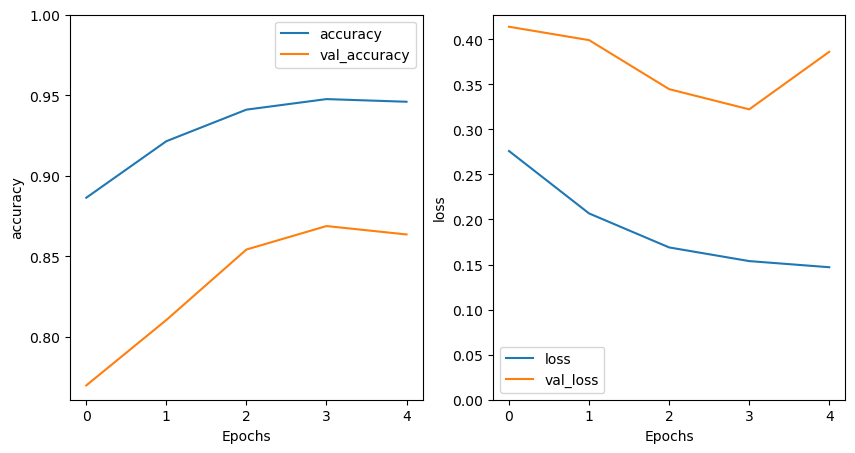

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_graphs(history,'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history,'loss')
plt.ylim(0,None)
plt.show()